***Google Colab -> Cette cellule est à executer (1 fois) pour le cloner le dépot en local***

In [ ]:
!git clone https://github.com/ManDes71/Rakuten_Text_Classification_ML.git

***Google Colab -> Cette cellule est à executer (1 fois) pour installer lee bibliothèques nécessaires***

In [ ]:
import sys
sys.path.append('/content/Rakuten_Text_Classification_ML')

!pip install -r /content/Rakuten_Text_Classification_ML/requirements.txt

Ce notebook fait partie d'un ensemble de sous-projets dont le resultat représente le **projet Rakuten** que j'ai réalisé pour mon diplôme de data Scientist chez Datascientest.com.  
Ce projet consiste en la classification à grande échelle des données de         produits multimodales (texte et image) en type de produits.  
Ce repositery est la partie **Machine Learning** et ne traite que de la partie texte.   
Il utilise néanmoins la bibliothèque **Bibli_DataScience** commune à l'ensemble du projet.  
D'autres dépots viendront, à savoir  :


*   La partie image  traitée par des réseaux convolutifs
*   La partie texte  traitée par des réseaux récurrents
*   Une quatrième partie qui est une syntèse par le media Streamlit



PROJET RAKUTEN
1) Description du projet
Description du problème
L'objectif de ce défi est la classification à grande échelle des données de produits
multimodales (texte et image) en codes de type de produit.
Par exemple, dans le catalogue de Rakuten France, un produit avec une désignation ou
un titre français "Klarstein Présentoir 2 Montres Optique Fibre" associé à une image et
parfois à une description supplémentaire. Ce produit est catégorisé sous le code de type
de produit 1500. Il existe d'autres produits avec des titres différents, des images
différentes et éventuellement des descriptions, qui appartiennent au même code de type
de produit. En utilisant ces informations sur les produits, comme l'exemple ci-dessus, ce
défi propose de modéliser un classificateur pour classer les produits dans leur code de
type de produit correspondant.
2) Introduction
le but du projet est de prédire le code de type de chaque produit tel que défini dans le
catalogue de Rakuten France.
La catégorisation des annonces de produits se fait par le biais de la désignation, de la
description (quand elle est présente) et des images.
Les fichiers de données sont distribués ainsi :
X_train_update.csv : fichier d'entrée d'entraînement
Y_train_CVw08PX.csv : fichier de sortie d'entraînement
X_test_update.csv : fichier d'entrée de test
Un fichier images.zip est également fourni, contenant toutes les images. La
décompression de ce fichier fournira un dossier nommé "images" avec deux sous-dossiers
nommés "image_training" et "image_test", contenant respectivement les images
d'entraînement et de test.
Pour notre part, ne participant pas au challenge Rakuten, nous n’aurons pas accès au
fichier de sortie de test. Le fichier d’entrée de test est donc inutilisable.
X_train_update.csv : fichier d'entrée d'entraînement :
La première ligne des fichiers d'entrée contient l'en-tête et les colonnes sont séparées par
des virgules (","). Les colonnes sont les suivantes :
Un identifiant entier pour le produit. Cet identifiant est utilisé pour associer le produit à son
code de type de produit correspondant.
Désignation - Le titre du produit, un court texte résumant le produit.
Description - Un texte plus détaillé décrivant le produit. Tous les marchands n'utilisent pas
ce champ, il se peut donc que le champ de description contienne la valeur NaN pour de
1
nombreux produits, afin de conserver l'originalité des données.
productid - Un identifiant unique pour le produit.
imageid - Un identifiant unique pour l'image associée au produit.
Les champs imageid et productid sont utilisés pour récupérer les images dans le dossier
d'images correspondant. Pour un produit donné, le nom du fichier image est :
image_imageid_product_productid.jpg ex : image_1263597046_product_3804725264.jpg
Y_train_CVw08PX.csv : fichier de sortie d'entraînement :
La première ligne des fichiers d'entrée contient l'en-tête et les colonnes sont séparées par
des virgules (","). Les colonnes sont les suivantes :
Un identifiant entier pour le produit. Cet identifiant est utilisé pour associer le produit à son
code de type de produit correspondant.
prdtypecode – Catégorie dans laquelle le produit est classé.
La liaison entre les fichiers se fait par une jointure sur l’identifiant entier présent les deux
fichiers.

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_colwidth', 150)

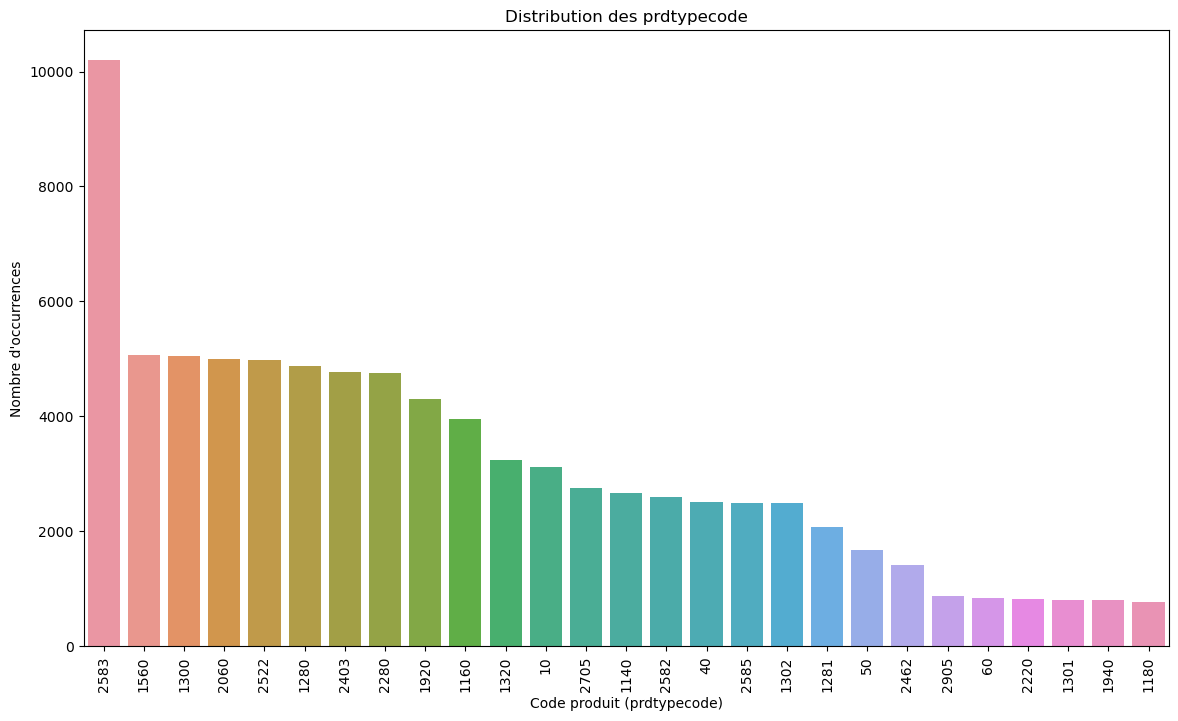

il y a une grande disparité dans la répartition des classes !


In [30]:
# lecture des données sources d'entrainement 
df_feats=pd.read_csv('X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv('Y_train_CVw08PX.csv')

# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)


cat=df_target['prdtypecode'].unique()

plt.figure(figsize=(14, 8))  
sns.countplot(data=df_target, x='prdtypecode', order = df_target['prdtypecode'].value_counts().index)
plt.xticks(rotation=90)  # Rotation des labels de l'axe x pour une meilleure lisibilité
plt.title("Distribution des prdtypecode")
plt.xlabel("Code produit (prdtypecode)")
plt.ylabel("Nombre d'occurrences")
plt.show()

print("il y a une grande disparité dans la répartition des classes !")


## exploration du dataset .

In [31]:
print("----df_feats info-------")
print(df_feats.info())
print("-"*50)
print("Le champ description n'est pas toujours présent.")
print("-"*50)
# Calcul de la moyenne des longueurs pour chaque colonne séparément
moyenne_designation = df_feats['designation'].str.len().mean()
moyenne_description = df_feats['description'].str.len().mean()

print("Moyenne de la longueur des designations:", moyenne_designation)
print("Moyenne de la longueur des descriptions:", moyenne_description)


----df_feats info-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB
None
--------------------------------------------------
Le champ description n'est pas toujours présent.
--------------------------------------------------
Moyenne de la longueur des designations: 70.16330255782185
Moyenne de la longueur des descriptions: 808.1716924305102


## J'examine les valeurs nulles et les doublons du champ 'designation'.

In [44]:
print("-----------------------------------------------------")
print("----'Nb designations non nulles' -----------------------")
print(len(df_feats[~df_feats['designation'].isna()]))
print("-----------------------------------------------------")
print("----'Nb de designations uniques' -------")
print(len(df_feats['designation'].unique()))
print("-----------------------------------------------------")
print("----'designation value_counts()' -------")
print("-----------------------------------------------------")
print(df_feats['designation'].value_counts().head())




-----------------------------------------------------
----'Nb designations non nulles' -----------------------
84916
-----------------------------------------------------
----'Nb de designations uniques' -------
82265
-----------------------------------------------------
----'designation value_counts()' -------
-----------------------------------------------------
designation
5d Broderie Peintures Strass Diamant Bricolage Pasted Peinture Point De Croix       76
Simple Linen Creative Belle Oreiller Taie D'oreiller Taie D'oreiller Car Cover      28
Cotton Linen Place Décoratifs Pour La Maison Coussin Case Canapé Taille Coussin     25
Imprimer Taie Polyester Canapé Coussin Car Cover Home Decor                         22
Joyeuse Saint-Valentin Jetez Taie D'oreiller Sweet Love Coussin Carré Couverture    21
Name: count, dtype: int64


## Etude des libellés 'designation' les plus fréquents

                                                                       designation  \
0    5d Broderie Peintures Strass Diamant Bricolage Pasted Peinture Point De Croix   
1  Cotton Linen Place Décoratifs Pour La Maison Coussin Case Canapé Taille Coussin   
2  Cotton Linen Place Décoratifs Pour La Maison Coussin Case Canapé Taille Coussin   
3   Simple Linen Creative Belle Oreiller Taie D'oreiller Taie D'oreiller Car Cover   

  prdtypecode  count  
0        2060     76  
1        1560      1  
2        1920     24  
3        1920     28  


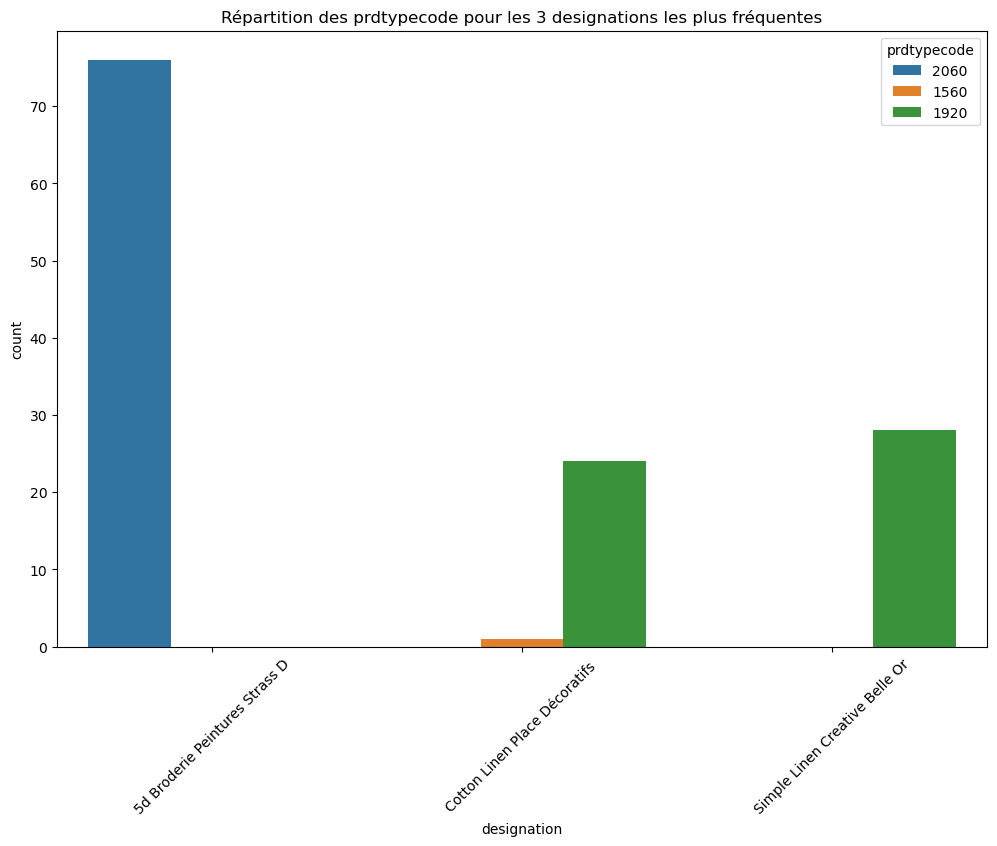

les designations en doublon appartiennent dans l'ensemble à la même classe.
Ce qui est une bonne chose !


In [56]:
nb_designation = df['designation'].value_counts()

top_3_designation = nb_designation.nlargest(3).index.tolist()

df_filtre = df[df['designation'].isin(top_3_designation)]


df_gr = df_filtre.groupby(['designation', 'prdtypecode']).size().reset_index(name='count')
df_gr['prdtypecode'] = df_gr['prdtypecode'].astype(str)

print(df_gr)

plt.figure(figsize=(12, 8))
sns.barplot(x='designation', y='count', hue='prdtypecode', data=df_gr)
plt.xticks(rotation=45)
plt.gca().set_xticklabels([label.get_text()[:30] for label in plt.gca().get_xticklabels()])
plt.title('Répartition des prdtypecode pour les 3 designations les plus fréquentes')
plt.show()

print("les designations en doublon appartiennent dans l'ensemble à la même classe.")
print("Ce qui est une bonne chose !")

## J'examine les valeurs nulles et les doublons du champ 'description'.

In [45]:
print("-----------------------------------------------------")
print("----'Nb descriptions non nulles' -----------------------")
print(len(df_feats[~df_feats['description'].isna()]))
print("-----------------------------------------------------")
print("----'Nb descriptions uniques' -----------------------")
print(len(df_feats['description'].unique()))
print("-----------------------------------------------------")
print("----'description value_counts()' -------")
print("-----------------------------------------------------")
print(df_feats['description'].value_counts().head())



-----------------------------------------------------
----'Nb descriptions non nulles' -----------------------
55116
-----------------------------------------------------
----'Nb descriptions uniques' -----------------------
47507
-----------------------------------------------------
----'description value_counts()' -------
-----------------------------------------------------
description
<br>Attention !!! Ce produit est un import  si les informations 'langues' et 'sous-titres' n'apparaissent pas sur cette fiche produit c'est que l'éditeur ne nous les a pas fournies. Néanmoins dans la grande majorité de ces cas il n'existe ni langue ni sous titres en français sur ces imports.    252
Taille: En format A5 (144 cm x 21 cm) Caractéistique: -Excellente durabilité avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualitévous pouvez y érire facilement                                                                                      232
Taille: 

In [ ]:
## Etude des libellés 'description' les plus fréquents

                                                                                                                                             description  \
0  <br>Attention !!! Ce produit est un import  si les informations 'langues' et 'sous-titres' n'apparaissent pas sur cette fiche produit c'est que l'...   
1  Taille: En format A5 (144 cm x 21 cm) Caracteristique: -Excellente durabilite avec couverture solide design. 96 pages jaune pale (recto et verso) ...   
2  Taille: En format A5 (144 cm x 21 cm) Caractéistique: -Excellente durabilité avec couverture solide design. 96 pages jaune pale (recto et verso) -...   

  prdtypecode  count  
0          40    252  
1        2522    189  
2        2522    232  


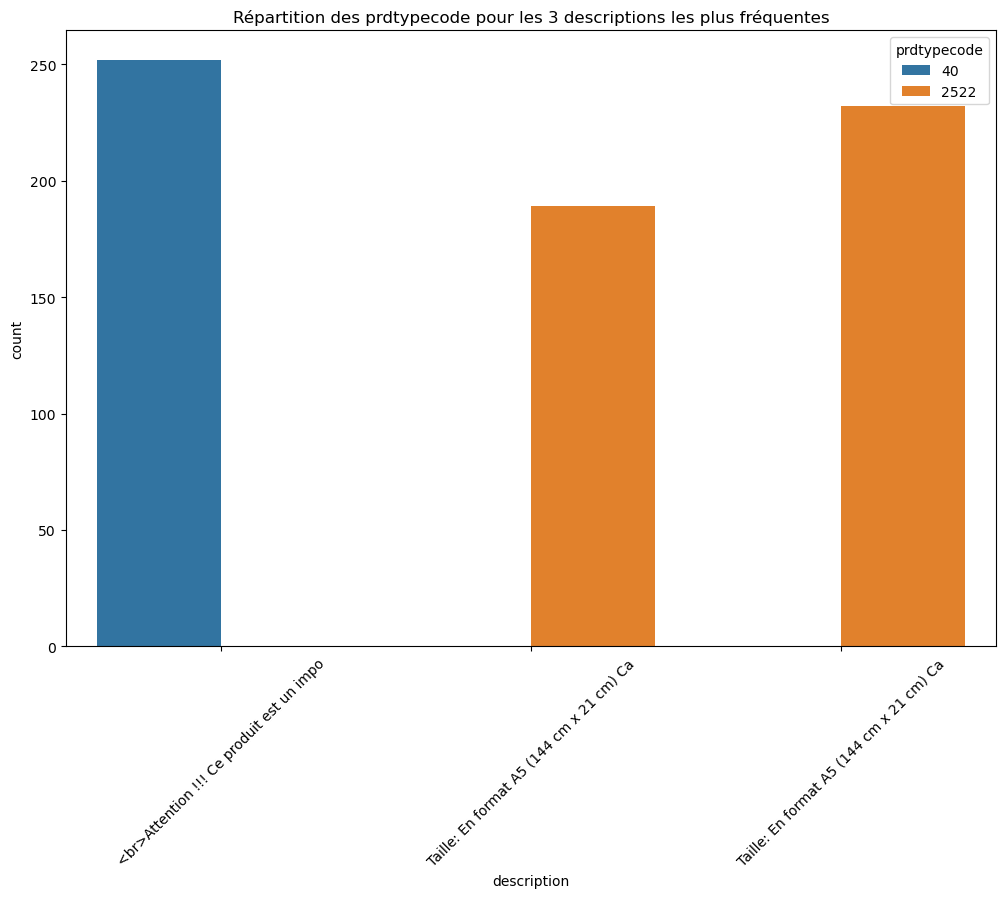

les description en doublon appartiennent  à la même classe.
Ce qui est une bonne chose !


In [57]:
nb_description = df['description'].value_counts()

top_3_designation = nb_description.nlargest(3).index.tolist()

df_filtre = df[df['description'].isin(top_3_designation)]

df_gr = df_filtre.groupby(['description', 'prdtypecode']).size().reset_index(name='count')


df_gr['prdtypecode'] = df_gr['prdtypecode'].astype(str)

print(df_gr)

plt.figure(figsize=(12, 8))
sns.barplot(x='description', y='count', hue='prdtypecode', data=df_gr)
plt.xticks(rotation=45)
plt.gca().set_xticklabels([label.get_text()[:40] for label in plt.gca().get_xticklabels()])
plt.title('Répartition des prdtypecode pour les 3 descriptions les plus fréquentes')
plt.show()

print("les description en doublon appartiennent  à la même classe.")
print("Ce qui est une bonne chose !")

## les descriptions en doublon appartiennent  à la même classe.


## Exploration de la valeur cible

In [16]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Unnamed: 0   84916 non-null  int64
 1   prdtypecode  84916 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB


In [26]:
print("-----------------------------------------------------")

print("----'nb productid unique' -------")
print(len(df_feats['productid'].unique()))
print("productid est unique et peut servir de clef ! ")

-----------------------------------------------------
----'nb productid unique' -------
84916
productid est unique et peut servir de clef ! 


# Proposition de nomenclature des classes ("prdtypecode")

In [15]:
nomenclature=pd.read_csv('NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']
catdict

{10: 'livres',
 40: 'jeux video pour pc et consoles',
 50: ' accesoires jeux video',
 60: 'consoles de jeux video',
 1140: 'produits derives “geeks” et figurines',
 1160: 'cartes collectionables',
 1180: 'figurines collectionables pour jeux de societe',
 1280: 'jouets, peluches, puppets',
 1281: 'jeux de societe/cartes',
 1300: 'Petites voitures (jouets) et maquettes',
 1301: 'accesoires pour petis enfants/bebes et mobilier de jeu (flechettes, billard, babyfoot)',
 1302: "jeux d'exterieur",
 1320: 'sacs pour femmes et accesore petite enfance',
 1560: 'Mobilier et produits decoration/rangement pour la maison',
 1920: 'linge de maison (cousins, rideaux, serviettes, nappes, draps)',
 1940: 'nouriture (cafes,infusions,conserves, epices,etc)',
 2060: 'lampes et accesoires decoration pour maison',
 2220: 'accesoires mascots/pets',
 2280: 'magazines',
 2403: 'livres et bds',
 2462: 'consoles de jeux video et jeux videos',
 2522: 'produits de papeterie et rangement bureau',
 2582: "mobilier d'